# VocalFoldTracker: Automated Glottal Area Segmentation

## Interactive Demo Notebook

This notebook demonstrates the **VocalFoldTracker** algorithm for automated segmentation and analysis of glottal area in high-speed laryngeal videos.

### What This Notebook Does

1. **Implements the VocalFoldTracker algorithm** - Based on motion-based ROI detection with percentile-based thresholding
2. **Provides interactive parameter tuning** - Real-time visualization with OpenCV sliders
3. **Extracts quantitative waveforms** - Glottal area, width, and edge position measurements over time
4. **Generates publication-ready visualizations** - Debug views and waveform plots

### Key Features

- ✅ **Motion-based ROI detection** - Automatically tracks vocal fold region
- ✅ **Percentile-based thresholding** - Robust to varying lighting and glare
- ✅ **Interactive parameter tuning** - Real-time feedback with sliders
- ✅ **Waveform extraction** - Quantitative measurements for clinical analysis
- ✅ **Debug visualization** - Multi-panel view of processing stages

### Requirements

This notebook requires OpenCV, NumPy, and Matplotlib. Run the installation cell below to set up dependencies.

---

## Installation

In [1]:
%pip install -q zenodo-get transformers datasets accelerate
%pip install opencv-python
%pip install numpy
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Vocal Fold Tracker Implementation

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

# --- 1. The Tracker Class ---

class VocalFoldTracker:
    """
    Implements the vocal fold edge detection algorithm described in the dissertation
    "ANALYSIS OF VOCAL FOLD KINEMATICS USING HIGH SPEED VIDEO" by H. Unnikrishnan.

    This class tracks the vocal fold edges from a sequence of video frames by:
    1. Maintaining an adaptive Region of Interest (ROI) based on motion.
    2. Performing robust, adaptive intensity thresholding within the ROI.
    3. Extracting the final edge contour using a Canny edge detector.
    """

    def __init__(self, alpha=0.96, beta=0.8, roi_threshold_ratio=0.1, gaussian_ksize=21, 
                 debug=False, glottal_percentile=None, max_glottal_components=2):
        """
        Initializes the tracker with parameters described in the dissertation.

        Args:
            alpha (float): The update factor for the motion likelihood map (ROI).
                           A higher value adapts more quickly and retains motion longer. (Eq. 2.13)
            beta (float): The forgetting factor for the adaptive segmentation threshold.
                          (Eq. 2.16)
            roi_threshold_ratio (float): The ratio of the max likelihood to use as a
                                         threshold for the ROI mask.
            gaussian_ksize (int): The kernel size for the Gaussian blur applied to
                                  the motion map. Should be an odd number.
            debug (bool): If True, stores and returns debug information.
            glottal_percentile (float): If set, use this percentile as threshold instead of Otsu.
                                        E.g., 10 means only pixels darker than 10th percentile
                                        are marked as glottal area. Lower = only darkest pixels.
            max_glottal_components (int): Maximum number of connected components to retain
                                          in final glottal area (1 or 2). Keeps largest components.
        """
        # --- Parameters ---
        self.alpha = alpha
        self.beta = beta
        self.roi_threshold_ratio = roi_threshold_ratio
        self.gaussian_ksize = (gaussian_ksize, gaussian_ksize)
        self.debug = debug
        self.glottal_percentile = glottal_percentile
        self.max_glottal_components = max_glottal_components

        # --- State Variables ---
        self.prev_frame_float = None
        self.likelihood_map = None
        self.adaptive_threshold = None
        self.roi_threshold = None
        self.is_initialized = False
        
        # --- Debug Info ---
        self.debug_info = {}

    def initialize(self, initial_frames: list):
        """
        Initializes the tracker using a sequence of initial frames.
        This computes the initial motion likelihood map and segmentation threshold.

        Args:
            initial_frames (list): A list of the first N frames (as NumPy arrays)
                                   of the video sequence.
        """
        if len(initial_frames) < 2:
            raise ValueError("Initialization requires at least two frames.")

        print(f"Initializing tracker with {len(initial_frames)} frames...")

        # --- Step 1: Initial Region of Interest (ROI) Extraction (Eq. 2.12) ---
        # Convert frames to float for more precise calculations
        float_frames = [frame.astype(np.float32) for frame in initial_frames]
        
        # Calculate the average of absolute frame differences
        avg_diff = np.zeros_like(float_frames[0])
        for i in range(1, len(float_frames)):
            diff = cv2.absdiff(float_frames[i], float_frames[i-1])
            avg_diff += diff
        avg_diff /= (len(float_frames) - 1)

        # Smooth the likelihood map with a Gaussian kernel
        self.likelihood_map = cv2.GaussianBlur(avg_diff, self.gaussian_ksize, 0)

        # The ROI threshold is determined from this initial map
        self.roi_threshold = np.max(self.likelihood_map) * self.roi_threshold_ratio

        # --- Step 2: Initial Robust Intensity Thresholding (Eq. 2.15) ---
        # Use the last frame of the sequence for the initial threshold calculation
        last_frame = initial_frames[-1]
        
        # Get the initial ROI mask
        _, roi_mask = cv2.threshold(self.likelihood_map, self.roi_threshold, 255, cv2.THRESH_BINARY)
        roi_mask = self._get_largest_blob(roi_mask.astype(np.uint8))

        # Calculate threshold on pixels within the ROI
        pixels_in_roi = last_frame[roi_mask == 255]
        if pixels_in_roi.size > 0:
            if self.glottal_percentile is not None:
                # Use percentile-based threshold to capture only darkest pixels
                self.adaptive_threshold = np.percentile(pixels_in_roi, self.glottal_percentile)
            else:
                # Use Otsu's method with glare clipping
                percentile_90 = np.percentile(pixels_in_roi, 90)
                clipped_pixels = np.clip(pixels_in_roi, 0, percentile_90).astype(np.uint8)
                self.adaptive_threshold, _ = cv2.threshold(
                    clipped_pixels, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
                )
        else:
            # Retain the old value
            self.adaptive_threshold = self.adaptive_threshold or 127.0

        self.prev_frame_float = float_frames[-1]
        self.is_initialized = True
        print(f"Tracker initialized. Initial threshold: {self.adaptive_threshold:.2f}")

    def _get_largest_blob(self, binary_mask: np.ndarray) -> np.ndarray:
        """Finds the largest connected component (blob) in a binary mask."""
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return np.zeros_like(binary_mask)

        largest_contour = max(contours, key=cv2.contourArea)
        
        clean_mask = np.zeros_like(binary_mask)
        cv2.drawContours(clean_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        return clean_mask

    def _get_largest_n_blobs(self, binary_mask: np.ndarray, n: int = 2) -> np.ndarray:
        """
        Finds the largest N connected components in a binary mask.
        
        Args:
            binary_mask: Binary mask to process
            n: Maximum number of components to retain (default: 2)
            
        Returns:
            Binary mask with only the largest N components
        """
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return np.zeros_like(binary_mask)

        # Sort contours by area in descending order
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        # Keep only the largest N contours
        largest_n_contours = sorted_contours[:min(n, len(sorted_contours))]
        
        # Create clean mask with only these contours
        clean_mask = np.zeros_like(binary_mask)
        cv2.drawContours(clean_mask, largest_n_contours, -1, 255, thickness=cv2.FILLED)
        
        return clean_mask

    def process_frame(self, frame: np.ndarray):
        """
        Processes a single video frame to detect the vocal fold contour.

        Args:
            frame (np.ndarray): The input grayscale video frame.

        Returns:
            A tuple containing:
            - contour_img (np.ndarray): A binary image showing the detected edge.
            - roi_mask (np.ndarray): The calculated Region of Interest for this frame.
            - glottal_area (np.ndarray): The segmented glottal area.
        """
        if not self.is_initialized:
            raise RuntimeError("Tracker has not been initialized. Call initialize() first.")

        frame_float = frame.astype(np.float32)

        # --- Step 1: Update Region of Interest (ROI) (Eq. 2.13) ---
        frame_diff = cv2.absdiff(frame_float, self.prev_frame_float)
        blurred_diff = cv2.GaussianBlur(frame_diff, self.gaussian_ksize, 0)
        
        # Update the likelihood map with the new frame's motion information
        # Higher alpha retains motion information for longer
        self.likelihood_map = self.alpha * blurred_diff + (1 - self.alpha) * self.likelihood_map
        
        # Binarize the likelihood map to get the ROI and keep the largest component
        _, roi_mask_raw = cv2.threshold(self.likelihood_map, self.roi_threshold, 255, cv2.THRESH_BINARY)
        roi_mask = self._get_largest_blob(roi_mask_raw.astype(np.uint8))

        # --- Step 2: Update Robust Intensity Threshold (Eq. 2.16) ---
        pixels_in_roi = frame[roi_mask == 255]
        current_otsu_thresh = self.adaptive_threshold # Use previous if ROI is empty
        percentile_90 = None
        percentile_glottal = None
        
        if pixels_in_roi.size > 10: # Ensure enough pixels for a stable threshold
            if self.glottal_percentile is not None:
                # Use percentile-based threshold to capture only darkest pixels
                percentile_glottal = np.percentile(pixels_in_roi, self.glottal_percentile)
                current_otsu_thresh = percentile_glottal
            else:
                # Clip extreme bright values (glare) at 90th percentile to avoid skewing
                percentile_90 = np.percentile(pixels_in_roi, 90)
                clipped_pixels = np.clip(pixels_in_roi, 0, percentile_90).astype(np.uint8)
                
                current_otsu_thresh, _ = cv2.threshold(
                    clipped_pixels, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
                )

        # Update the adaptive threshold using the forgetting factor
        self.adaptive_threshold = self.beta * self.adaptive_threshold + (1 - self.beta) * current_otsu_thresh

        # --- Step 3: Segmentation and Contour Extraction ---
        # Segment the glottal area using the adaptive threshold within the ROI (Eq. 2.17)
        glottal_area_raw = np.zeros_like(frame, dtype=np.uint8)
        glottal_area_raw[(frame < self.adaptive_threshold) & (roi_mask == 255)] = 255

        # --- Step 4: Post-processing - Keep only largest N components ---
        # This removes noise and small artifacts, keeping only the main glottal opening(s)
        glottal_area = self._get_largest_n_blobs(glottal_area_raw, n=self.max_glottal_components)

        # Extract the final contour using Canny edge detector
        # The paper uses thresholds of 30 and 60.
        contour_img = cv2.Canny(glottal_area, 30, 60)

        # --- Store Debug Information ---
        if self.debug:
            self.debug_info = {
                'frame': frame.copy(),
                'likelihood_map': self.likelihood_map.copy(),
                'roi_mask': roi_mask.copy(),
                'glottal_area': glottal_area.copy(),
                'contour': contour_img.copy(),
                'adaptive_threshold': self.adaptive_threshold,
            }

        # Update state for the next frame
        self.prev_frame_float = frame_float

        return contour_img, roi_mask, glottal_area

    def extract_glottal_area(self, glottal_area_mask: np.ndarray) -> float:
        """
        Extract the glottal area (pixel count) from a binary mask.

        Args:
            glottal_area_mask: Binary mask where 255 = glottal opening

        Returns:
            Area in pixels
        """
        return np.sum(glottal_area_mask == 255)

    def extract_glottal_width(self, glottal_area_mask: np.ndarray) -> tuple:
        """
        Extract the glottal width by finding the distance between
        leftmost and rightmost points of the glottal opening.

        Args:
            glottal_area_mask: Binary mask where 255 = glottal opening

        Returns:
            Tuple of (width_pixels, left_x, right_x, mid_y)
            Returns (0, 0, 0, 0) if no glottal area detected
        """
        # Find all glottal pixels
        y_coords, x_coords = np.where(glottal_area_mask == 255)

        if len(x_coords) == 0:
            return (0, 0, 0, 0)

        # Find leftmost and rightmost points
        left_x = np.min(x_coords)
        right_x = np.max(x_coords)
        width = right_x - left_x

        # Find midline y-coordinate (median)
        mid_y = int(np.median(y_coords))

        return (width, left_x, right_x, mid_y)

    def process_video_batch(self, frames: list, start_frame: int = 0):
        """
        Process a batch of frames and extract waveforms.

        Args:
            frames: List of video frames
            start_frame: Frame index to start processing from (default: 0)

        Returns:
            Dictionary containing:
            - 'glottal_area': Array of glottal area over time (pixels)
            - 'glottal_width': Array of glottal width over time (pixels)
            - 'left_edge': Array of left edge x-positions over time
            - 'right_edge': Array of right edge x-positions over time
            - 'frame_indices': Array of frame indices
        """
        if not self.is_initialized:
            raise RuntimeError("Tracker must be initialized before batch processing.")

        num_frames = len(frames) - start_frame

        # Initialize arrays
        glottal_areas = np.zeros(num_frames)
        glottal_widths = np.zeros(num_frames)
        left_edges = np.zeros(num_frames)
        right_edges = np.zeros(num_frames)

        print(f"Processing {num_frames} frames for waveform extraction...")

        for i, frame_idx in enumerate(range(start_frame, len(frames))):
            frame = frames[frame_idx]

            # Process frame
            contour, roi_mask, glottal_area = self.process_frame(frame)

            # Extract measurements
            glottal_areas[i] = self.extract_glottal_area(glottal_area)
            width, left_x, right_x, mid_y = self.extract_glottal_width(glottal_area)
            glottal_widths[i] = width
            left_edges[i] = left_x
            right_edges[i] = right_x

            # Progress indicator
            if (i + 1) % 500 == 0:
                print(f"  Processed {i + 1}/{num_frames} frames...")

        print(f"Batch processing complete.")

        return {
            'glottal_area': glottal_areas,
            'glottal_width': glottal_widths,
            'left_edge': left_edges,
            'right_edge': right_edges,
            'frame_indices': np.arange(start_frame, len(frames))
        }

    def show_debug(self, figsize=(15, 10)):
        """
        Display debug visualization showing key processing stages.
        
        Args:
            figsize: Size of the matplotlib figure
        """
        if not self.debug or not self.debug_info:
            print("Debug mode not enabled or no debug info available. Set debug=True when creating tracker.")
            return
        
        info = self.debug_info
        
        fig = plt.figure(figsize=figsize)
        
        # 1. Original frame (input) - NOW FIRST
        ax1 = plt.subplot(2, 3, 1)
        plt.imshow(info['frame'], cmap='gray')
        plt.title('Input Frame', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 2. Likelihood map (probability map)
        ax2 = plt.subplot(2, 3, 2)
        plt.imshow(info['likelihood_map'], cmap='hot')
        plt.title('Motion Likelihood Map', fontsize=12, fontweight='bold')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
        
        # 3. Glottal area after all processing
        ax3 = plt.subplot(2, 3, 3)
        plt.imshow(info['glottal_area'], cmap='gray')
        glottal_pixel_count = np.sum(info['glottal_area'] == 255)
        plt.title(f'Glottal Area (Final)\n{glottal_pixel_count} pixels', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 4. Glottal area overlayed on original frame
        ax4 = plt.subplot(2, 3, 4)
        overlay = cv2.cvtColor(info['frame'], cv2.COLOR_GRAY2RGB)
        overlay[info['glottal_area'] == 255] = [0, 255, 0]  # Green
        plt.imshow(overlay)
        plt.title('Glottal Area Overlay', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 5. Contour
        ax5 = plt.subplot(2, 3, 5)
        plt.imshow(info['contour'], cmap='gray')
        plt.title('Edge Contour (Canny)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 6. Statistics
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        stats_text = f"""
        Statistics:
        ─────────────────────
        
        Glottal Area: {glottal_pixel_count} pixels
        Threshold: {info['adaptive_threshold']:.2f}
        
        Parameters:
        • alpha: {self.alpha}
        • beta: {self.beta}
        • ROI ratio: {self.roi_threshold_ratio}
        • Max components: {self.max_glottal_components}
        """
        plt.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center')
        
        plt.tight_layout()
        plt.show()


---

## VocalFoldTracker Algorithm Implementation

The core algorithm implements motion-based ROI detection combined with adaptive thresholding for robust glottal area segmentation.

### Algorithm Overview

1. **Motion Detection** - Tracks frame-to-frame differences to identify vocal fold region
2. **Adaptive ROI** - Updates region of interest using exponential moving average
3. **Percentile Thresholding** - Uses Nth percentile of pixel intensities (default: 5th) to segment darkest regions
4. **Glare Handling** - Clips top 10% of intensities to prevent specular reflections from skewing threshold
5. **Noise Removal** - Keeps largest 1-2 connected components
6. **Edge Extraction** - Canny edge detection for sub-pixel precision

### Key Parameters

- `alpha` (0.96-0.98): Motion retention factor - higher values retain motion information longer
- `beta` (0.7-0.8): Threshold adaptation rate
- `glottal_percentile` (5-15): Percentile threshold for segmentation - lower captures only darkest pixels
- `max_glottal_components` (1-2): Maximum number of blobs to retain

Run the cell below to load the complete tracker implementation.

---

## Step 1: Load High-Speed Video

Load your high-speed laryngeal video (AVI format). The video should be:
- **Grayscale** or will be converted to grayscale
- **High frame rate** (typically 2000-8000 fps)
- **Adequate spatial resolution** (glottal opening should be at least 10 pixels wide)

**Instructions:**
1. Update the `video_path` variable below to point to your video file
2. Run the cell to load all frames into memory

The video will be loaded as a list of NumPy arrays for processing.

In [ ]:
# Path to your AVI video (update if needed)
video_path = "your video.avi"

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {video_path}")

# Read all frames as grayscale
avi_frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    avi_frames.append(gray)

cap.release()

print(f"Loaded {len(avi_frames)} frames from {video_path}.")
if len(avi_frames) < 2:
    raise RuntimeError("Video must have at least 2 frames.")

Loaded 11928 frames from /Users/moluduttu/code/sdsc/glottal_area/Child subjects/P10MC_1NPNL2.avi.


---

## Step 2: Interactive ROI Selection

Manually select the Region of Interest (ROI) containing the vocal folds. This reduces computational cost and focuses the algorithm on the relevant anatomical region.

**How to use:**
1. A window will appear showing the first frame
2. **Click and drag** to draw a rectangle around the vocal fold region
3. Press **'c'** to confirm your selection
4. Press **'r'** to reset and try again
5. Press **'q'** to skip ROI selection (use full frame)

**Tip:** The ROI should include the entire glottal opening and surrounding tissue, but exclude unnecessary background regions.

In [ ]:
# --- Run tracker on AVI video with interactive ROI selection ---

import cv2
import numpy as np



# --- Interactive ROI selection on the first frame ---
roi = None
start_pt = None
end_pt = None
selecting = False

first_frame = avi_frames[0].copy()
preview = first_frame.copy()
win_name = "Select ROI (drag with mouse, press 'c' to confirm, 'r' to reset, 'q' to cancel)"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)


def on_mouse(event, x, y, flags, param):
    global start_pt, end_pt, selecting, preview
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_pt = (x, y)
        end_pt = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_pt = (x, y)
        preview = first_frame.copy()
        cv2.rectangle(preview, start_pt, end_pt, 255, 2)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_pt = (x, y)
        preview = first_frame.copy()
        cv2.rectangle(preview, start_pt, end_pt, 255, 2)


cv2.setMouseCallback(win_name, on_mouse)

while True:
    cv2.imshow(win_name, preview)
    key = cv2.waitKey(20) & 0xFF
    if key == ord('c') and start_pt is not None and end_pt is not None:
        x0, y0 = start_pt
        x1, y1 = end_pt
        x_min, x_max = sorted([x0, x1])
        y_min, y_max = sorted([y0, y1])
        w = max(1, x_max - x_min)
        h = max(1, y_max - y_min)
        roi = (x_min, y_min, w, h)
        break
    elif key == ord('r'):
        start_pt, end_pt, roi = None, None, None
        preview = first_frame.copy()
    elif key == ord('q'):
        roi = None
        break

cv2.destroyWindow(win_name)

if roi is None:
    print("No ROI selected, using full frame.")
    avi_video = avi_frames
else:
    x, y, w, h = roi
    print(f"Using ROI: x={x}, y={y}, w={w}, h={h}")
    avi_video = [f[y:y+h, x:x+w] for f in avi_frames]



Using ROI: x=50, y=119, w=131, h=185


---

## Step 3: Interactive Parameter Tuning

This interactive viewer allows you to tune algorithm parameters in real-time and see immediate visual feedback.

### Available Controls (Trackbars)

1. **alpha x100** (0-100): Motion retention factor
   - Higher = retains motion information longer
   - Recommended: 96-98 (pediatric), 94-96 (adult)

2. **beta x100** (0-100): Threshold adaptation rate
   - Higher = slower threshold updates
   - Recommended: 70-80

3. **ROI thr %** (1-100): ROI detection sensitivity
   - Lower = more restrictive ROI
   - Recommended: 5-10

4. **Gauss k (odd)** (1-15): Gaussian blur kernel size
   - Controls smoothing of motion map
   - Recommended: 5-7

5. **Glottal %ile** (1-50): Percentile threshold
   - Lower = captures only darkest pixels
   - Recommended: 2-10 (pediatric), 10-15 (adult)

6. **Overlay alpha** (0-100): Visualization transparency
   - Controls overlay opacity for better visualization

### Keyboard Shortcuts

- Press **'q'** to quit the viewer
- Press **'r'** to restart with current parameters

### Color Legend

- 🔵 **Blue**: Motion-detected ROI
- 🟢 **Green**: Detected glottal area
- 🔴 **Red**: Edge contours (Canny)

Run the cell below and adjust sliders to find optimal parameters for your video.

In [ ]:
# --- Interactive OpenCV viewer for AVI+ROI with parameter sliders ---

import cv2
import numpy as np

# Require that the AVI + optional ROI have been prepared in `avi_video`
if 'avi_video' not in globals() or len(avi_video) < 2:
    raise RuntimeError("Run the AVI + ROI cell first to populate `avi_video`.")

win_name = "AVI Tracker (press q to quit, r to restart)"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

prev_params_avi = {
    'alpha': None,
    'beta': None,
    'roi_ratio': None,
    'gauss_k': None,
    'glottal_percentile': None,
}

# Sliders - starting values optimized for glottal opening detection
cv2.createTrackbar('alpha x100', win_name, int(0.98 * 100), 100, lambda x: None)  # Higher = retain motion longer
cv2.createTrackbar('beta x100', win_name, int(0.7 * 100), 100, lambda x: None)
cv2.createTrackbar('ROI thr %', win_name, 5, 100, lambda x: None)  # 5% default
cv2.createTrackbar('Gauss k (odd)', win_name, 6, 15, lambda x: None)  # 2*6+1 = 13
cv2.createTrackbar('Glottal %ile', win_name, 5, 50, lambda x: None)  # 5th percentile = only darkest pixels
cv2.createTrackbar('Overlay alpha', win_name, 50, 100, lambda x: None)  # Overlay transparency (50% default)


def get_params_avi():
    alpha = cv2.getTrackbarPos('alpha x100', win_name) / 100.0
    beta = cv2.getTrackbarPos('beta x100', win_name) / 100.0
    roi_ratio = max(cv2.getTrackbarPos('ROI thr %', win_name), 1) / 100.0
    k_raw = cv2.getTrackbarPos('Gauss k (odd)', win_name)
    if k_raw < 1:
        k_raw = 1
    gauss_k = 2 * k_raw + 1
    glottal_percentile = max(cv2.getTrackbarPos('Glottal %ile', win_name), 1)  # At least 1
    overlay_alpha = cv2.getTrackbarPos('Overlay alpha', win_name) / 100.0
    return alpha, beta, roi_ratio, gauss_k, glottal_percentile, overlay_alpha


def params_changed_avi(alpha, beta, roi_ratio, gauss_k, glottal_percentile):
    changed = (
        prev_params_avi['alpha'] != alpha or
        prev_params_avi['beta'] != beta or
        prev_params_avi['roi_ratio'] != roi_ratio or
        prev_params_avi['gauss_k'] != gauss_k or
        prev_params_avi['glottal_percentile'] != glottal_percentile
    )
    prev_params_avi['alpha'] = alpha
    prev_params_avi['beta'] = beta
    prev_params_avi['roi_ratio'] = roi_ratio
    prev_params_avi['gauss_k'] = gauss_k
    prev_params_avi['glottal_percentile'] = glottal_percentile
    return changed


fps = 15
frame_delay_ms = int(1000 / fps)

tracker_live_avi = None
initial_frames_count_avi = min(50, len(avi_video) - 1)
current_idx_avi = initial_frames_count_avi
num_frames_avi = len(avi_video)

print("Starting AVI interactive viewer. Use sliders to tune parameters.")
print("Trackbars:")
print("  alpha x100: Motion retention (higher = retain longer)")
print("  Glottal %ile: Percentile threshold (lower = only darkest pixels)")
print("  Overlay alpha: Overlay transparency (higher = more opaque colors)")

while True:
    alpha, beta, roi_ratio, gauss_k, glottal_percentile, overlay_alpha = get_params_avi()

    # (Re)initialize tracker if first run or parameters changed
    if tracker_live_avi is None or params_changed_avi(alpha, beta, roi_ratio, gauss_k, glottal_percentile):
        if tracker_live_avi is not None:
            print(f"Parameters changed. Reinitializing with: alpha={alpha:.2f}, beta={beta:.2f}, "
                  f"roi_ratio={roi_ratio:.2f}, gauss_k={gauss_k}, "
                  f"glottal_percentile={glottal_percentile}")
        
        tracker_live_avi = VocalFoldTracker(
            alpha=alpha,
            beta=beta,
            roi_threshold_ratio=roi_ratio,
            gaussian_ksize=gauss_k,
            glottal_percentile=glottal_percentile
        )
        tracker_live_avi.initialize(avi_video[:initial_frames_count_avi])
        current_idx_avi = initial_frames_count_avi  # Reset to start

    if current_idx_avi >= num_frames_avi:
        current_idx_avi = initial_frames_count_avi

    frame = avi_video[current_idx_avi]
    
    contour, roi_mask, area = tracker_live_avi.process_frame(frame)

    # Convert grayscale to BGR (base frame)
    frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    # Create colored overlay
    overlay = np.zeros_like(frame_color)
    overlay[roi_mask == 255] = [255, 0, 0]       # ROI in blue
    overlay[area == 255] = [0, 255, 0]           # glottal area in green
    overlay[contour == 255] = [0, 0, 255]        # contour in red
    
    # Blend original frame with overlay using alpha blending
    frame_color = cv2.addWeighted(frame_color, 1 - overlay_alpha, overlay, overlay_alpha, 0)

    # Add text overlay showing current parameters
    text = f"Frame: {current_idx_avi}/{num_frames_avi} | Threshold: {tracker_live_avi.adaptive_threshold:.1f} | Glottal %ile: {glottal_percentile}"
    cv2.putText(frame_color, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow(win_name, frame_color)

    key = cv2.waitKey(frame_delay_ms) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        tracker_live_avi = None
        current_idx_avi = initial_frames_count_avi
        continue

    current_idx_avi += 1
    if current_idx_avi >= num_frames_avi:
        current_idx_avi = initial_frames_count_avi

cv2.destroyWindow(win_name)
print("Interactive viewer closed.")

Starting AVI interactive viewer. Use sliders to tune parameters.
Trackbars:
  alpha x100: Motion retention (higher = retain longer)
  Glottal %ile: Percentile threshold (lower = only darkest pixels)
  Overlay alpha: Overlay transparency (higher = more opaque colors)
Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 90.00
Parameters changed. Reinitializing with: alpha=0.98, beta=0.70, roi_ratio=0.05, gauss_k=13, glottal_percentile=5
Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 90.00
Parameters changed. Reinitializing with: alpha=0.98, beta=0.70, roi_ratio=0.05, gauss_k=13, glottal_percentile=1
Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 48.00
Parameters changed. Reinitializing with: alpha=0.98, beta=0.70, roi_ratio=0.05, gauss_k=13, glottal_percentile=2
Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 77.00


---

## Step 4: Debug Visualization

Generate a detailed multi-panel visualization showing all processing stages. This is useful for:
- Understanding how the algorithm works
- Verifying segmentation quality
- Creating figures for publications or presentations

### What's Displayed

1. **Input Frame** - Original grayscale video frame
2. **Motion Likelihood Map** - Heatmap showing detected motion (warmer = more motion)
3. **Glottal Area (Final)** - Binary segmentation after all processing
4. **Glottal Area Overlay** - Detection overlaid on original frame for visual verification
5. **Edge Contour (Canny)** - Sub-pixel edge detection
6. **Statistics Panel** - Current parameter values and measurements

Run the cell below to process a single frame and display the debug view.

Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 77.00


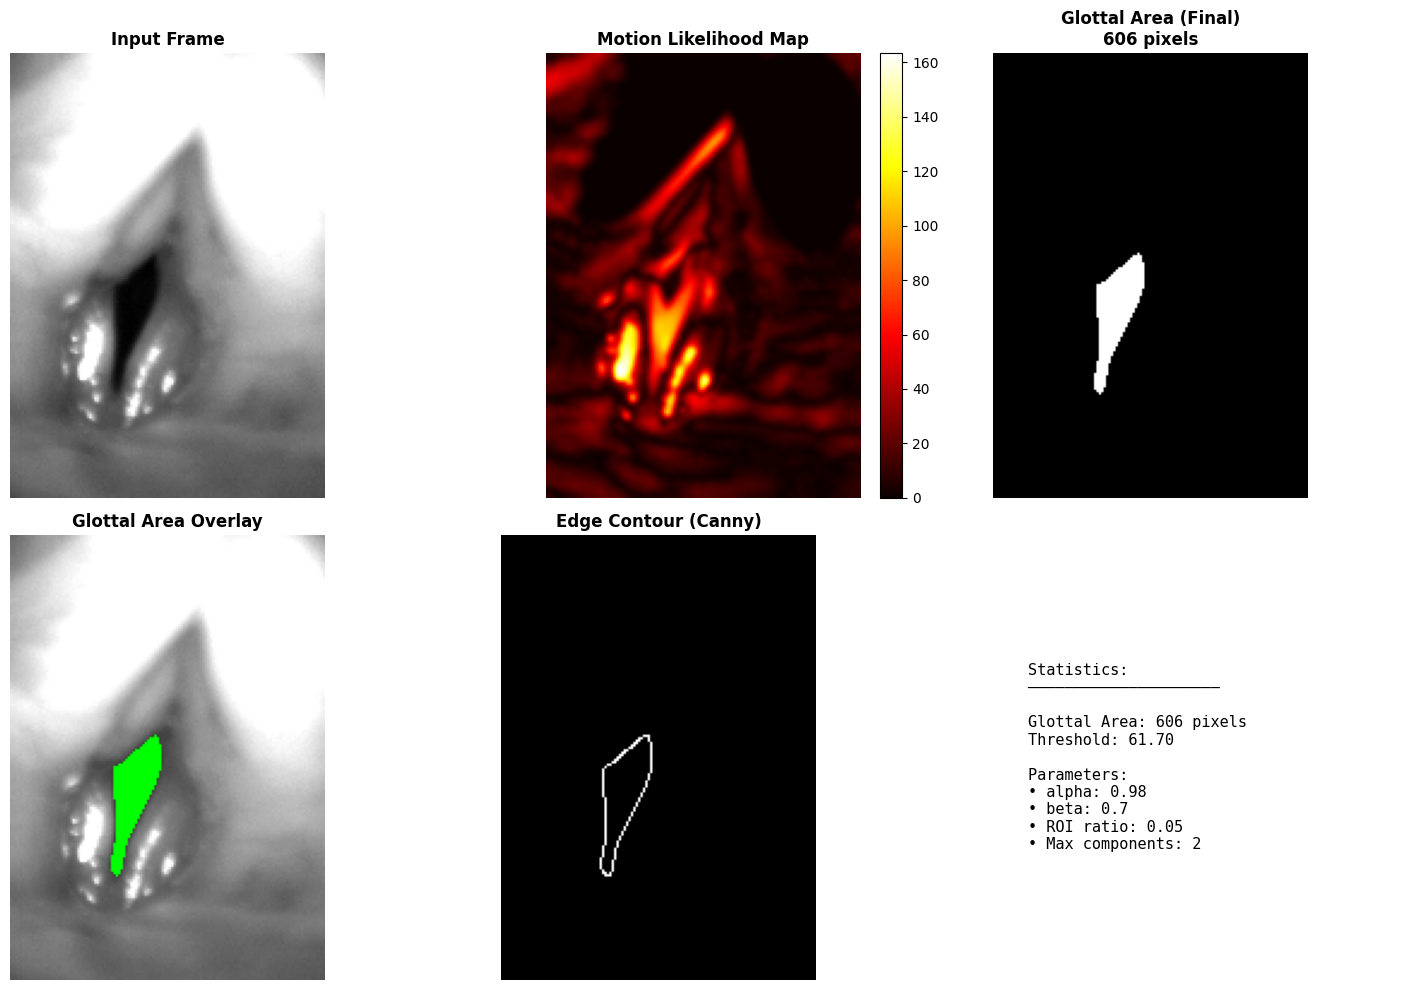

In [ ]:
# --- Use VocalFoldTracker to Display processing stages---

# Create tracker with:
# - Higher alpha (0.98) to retain motion longer
# - Percentile-based threshold (15th percentile = only darkest 15% of pixels)
tracker_debug = VocalFoldTracker(
    alpha=0.98,  # Higher = retains motion information longer
    beta=0.7,
    roi_threshold_ratio=0.05,
    gaussian_ksize=5,
    debug=True,  # Enable debug mode
    glottal_percentile=2  # Only pixels darker than 15th percentile = glottal area
)

# Initialize with first 50 frames from your video
initial_count = 50
tracker_debug.initialize(avi_video[:initial_count])

# Process a frame (e.g., frame 100)
test_frame_idx = 100
contour, roi, area = tracker_debug.process_frame(avi_video[test_frame_idx])

# Display simplified debug visualization
tracker_debug.show_debug(figsize=(15, 10))

---

## Utility: Close OpenCV Windows

Run this cell to ensure all OpenCV windows are properly closed (especially important on macOS).

In [39]:
# Close any lingering OpenCV windows
import cv2
cv2.destroyAllWindows()

# On macOS, call waitKey multiple times to ensure windows close
for i in range(5):
    cv2.waitKey(1)
    
print("OpenCV windows closed")

OpenCV windows closed


# Step 5: Waveform Extraction

Extract glottal area waveform and similar metric over time

Initializing tracker with 50 frames...
Tracker initialized. Initial threshold: 26.74
Processing 950 frames for waveform extraction...
  Processed 500/950 frames...
Batch processing complete.


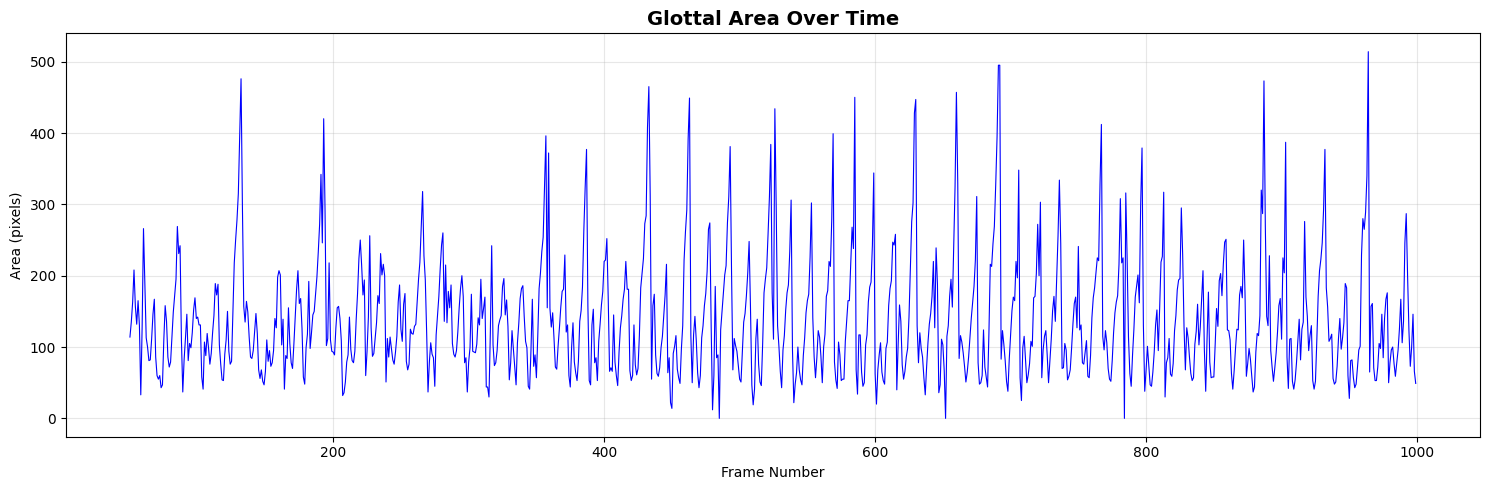


Waveform Statistics:
  Mean glottal area: 139.2 pixels
  Max glottal area: 514.0 pixels
  Min glottal area: 0.0 pixels


In [ ]:
# --- Extract Displacement Waveforms ---

# Create tracker for waveform extraction
tracker_waveform = VocalFoldTracker(
    alpha=0.98,
    beta=0.7,
    roi_threshold_ratio=0.10,
    gaussian_ksize=13,
    glottal_percentile=2
)

# Initialize with first 50 frames
init_count = 50
tracker_waveform.initialize(avi_video[:init_count])

# Process video and extract waveforms
# Use a subset for faster demo (e.g., 1000 frames)
max_frames_to_process = min(1000, len(avi_video))
waveforms = tracker_waveform.process_video_batch(avi_video[:max_frames_to_process], start_frame=init_count)

# Plot the glottal area waveform
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Glottal area over time
ax.plot(waveforms['frame_indices'], waveforms['glottal_area'], 'b-', linewidth=0.8)
ax.set_title('Glottal Area Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Area (pixels)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(images_dir, "displacement_waveforms.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nWaveform Statistics:")
print(f"  Mean glottal area: {np.mean(waveforms['glottal_area']):.1f} pixels")
print(f"  Max glottal area: {np.max(waveforms['glottal_area']):.1f} pixels")
print(f"  Min glottal area: {np.min(waveforms['glottal_area']):.1f} pixels")

---

## Summary and Next Steps

### What You've Accomplished

✅ Loaded and processed high-speed laryngeal video  
✅ Interactively selected ROI and tuned parameters  
✅ Generated debug visualizations to understand algorithm behavior  
✅ Extracted quantitative glottal area waveforms  
✅ Created publication-ready images  

### Recommended Workflow

1. **Parameter Tuning** - Use the interactive viewer (Step 3) to find optimal parameters for your specific video
2. **Verification** - Check the debug visualization (Step 4) to ensure segmentation quality
3. **Batch Processing** - Once parameters are set, process the full video using Step 6
4. **Analysis** - Export waveform data for frequency analysis, clinical measurements, or statistical comparisons

### Customization Tips

**For Pediatric Subjects:**
- Use lower `glottal_percentile` (2-5) for smaller glottal openings
- Increase `alpha` (0.98) for better motion retention
- Set `max_glottal_components=1` if opening is typically single blob

**For Adult Subjects:**
- Use higher `glottal_percentile` (10-15) for larger openings
- Standard `alpha` (0.96) works well
- Set `max_glottal_components=2` to handle anterior/posterior splits

**For Poor Quality Videos:**
- Increase `gaussian_ksize` (15-21) for more smoothing
- Adjust `roi_threshold_ratio` if ROI detection fails
- Lower `beta` (0.6-0.7) for faster threshold adaptation

### References

- **Unnikrishnan, H.** (2016). "Analysis of Vocal Fold Kinematics Using High Speed Video." PhD Dissertation, University of Kentucky.
- **Patel, R., Donohue, K. D., Unnikrishnan, H., & Kryscio, R. J.** (2015). "Kinematic measurements of the vocal-fold displacement waveform in typical children and adult populations." *Journal of Speech, Language, and Hearing Research*, 58(2), 300-313.

### Contact

For questions, bug reports, or collaboration opportunities, please reach out via the project repository or direct message.

---

**Note:** This is a case study demonstration. Formal validation is pending. The algorithm has been tested on pediatric and adult high-speed laryngeal videos with promising results, but clinical applications should be carefully validated.

---

## Step 6: Extract Glottal Area Waveform

Process the entire video (or a subset) to extract quantitative time-series measurements.

### Extracted Measurements

For each frame, the tracker computes:
- **Glottal area** - Total pixels in the glottal opening
- **Glottal width** - Distance between left and right edges
- **Left edge position** - X-coordinate of leftmost glottal pixel
- **Right edge position** - X-coordinate of rightmost glottal pixel

### Output

The waveform data can be used for:
- **Frequency analysis** - Fundamental frequency (F0) extraction via FFT
- **Amplitude measurements** - Peak-to-trough vibration amplitude
- **Cycle-to-cycle analysis** - Jitter, shimmer, irregularity detection
- **Open quotient calculation** - Ratio of open time to cycle period
- **Clinical comparisons** - Pre/post-treatment assessment

Run the cell below to process frames and generate the glottal area waveform plot.